**Vanilla Policy Gradient (VPG) Agent**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Policy(nn.Module):
    """ A Parameterized Policy Network π_θ """
    
    def __init__(self, n_obs_dim: int, n_action_dim: int, n_hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(n_obs_dim, n_hidden_dim)
        self.fc2 = nn.Linear(n_hidden_dim, n_action_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # reference: https://medium.com/aimonks/a-comprehensive-guide-to-activation-functions-in-deep-learning-ff794f87c184
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [2]:
import gym

# initialize environment
env = gym.make("CartPole-v1")

obs_space = env.observation_space.shape[0]
act_space = env.action_space.n

print(f"=== CartPole-v1 Environment ===")
print(f" Observation Space:", obs_space)
print(f" Action Space:", act_space)

=== CartPole-v1 Environment ===
 Observation Space: 4
 Action Space: 2


**Policy Gradient Theorem**

Policy gradient methods optimize a policy directly by maximizing the objective function $ J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ R(\tau) \right] $.  

The gradient of the expected return $ J(\theta)$  is given by  

$  \nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \nabla_\theta \left( R(\tau) \right) \right]. $

Using the log-likelihood trick, we can rewrite this gradient as  

$ \nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t | s_t) \cdot R_t \right] $

The contribution to the gradient from a single step is  

$\nabla_\theta \log \pi_\theta(a_t | s_t) \cdot R_t$

In [3]:
from torch.distributions import Categorical # discrete distribution
import numpy as np

from typing import *

class Agent():
    """ A Vanilla Policy Gradient (VPG) Agent """

    def __init__(self, obs_space: int, act_space: int):

        # set hyperparameters
        self.alpha = 1e-3 # learning rate
        self.gamma = 0.99 # discount factor

        self.gradient_clipping = 0.5 # for gradient clipping: https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem#:~:text=Gradient%20Clipping%20is%20a%20method,gradients%20to%20update%20the%20weights.
        self.entropy_regularization = 0.05 # for entropy regularization (promotes exploration): https://towardsdatascience.com/entropy-regularization-in-reinforcement-learning-a6fa6d7598df

        # initialize policy
        self.policy = Policy(obs_space, act_space)
        self.optimizer = torch.optim.AdamW(self.policy.parameters(), lr=self.alpha)

        self.eps = np.finfo(np.float32).eps.item() # utility: machine epsilon

    def select_action(self, state: np.ndarray) -> Tuple[int, torch.Tensor]:
        state = torch.from_numpy(state).float().unsqueeze(0)

        # apply policy to select action
        m = Categorical(self.policy(state)) # apply policy
        action = m.sample() # select action
        
        return action.item(), m.log_prob(action), m.entropy()


    def update_policy(self, rewards: List[float], log_probs: List[torch.Tensor], entropies: List[torch.Tensor]) -> float:
        """
        Update the policy using the policy gradient method.

        Args:
            rewards (List[float]): List of rewards from the environment.
            log_probs (List[torch.Tensor]): List of log probabilities of actions taken.
            entropies (List[torch.Tensor]): List of entropies.

        Returns:
            float: The computed loss for the policy update.
        """
        
        # compute returns
        R = 0
        returns = []
        for r in rewards[::-1]: # iterate backwards (to discount appropriately)
            R = r + self.gamma * R
            returns.insert(0, R)
        
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + self.eps) # normalization

        # compute loss
        loss = []
        for log_prob, R, entropy in zip(log_probs, returns, entropies):
            # maximize log_prob * R (expected return)
            loss.append((-log_prob * R) - (self.entropy_regularization * entropy)) # utility: - to convert gradient ascent to gradient
            # apply entropy regularization
        loss = torch.cat(loss).sum()

        # perform gradient descent (usual training process)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy.parameters(), self.gradient_clipping) # apply gradient clipping
        self.optimizer.step()

        return loss.item()

In [4]:
# initialize agent
agent = Agent(obs_space, act_space)

n_average = 50
threshold_loss = -10

history = []
n_trajectories = 800
for i in range(n_trajectories + 1):

    state = env.reset() # starting new trajectory

    rewards = [] # record sequence of rewards for policy update
    log_probs = [] # record sequence of log_probs for policy update

    entropies = [] # record sequence of entropies for entropy regularization

    T = 1000
    for t in range(1, T):

        # select action
        action, log_prob, entropy = agent.select_action(state)

        # get feedback from environment
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        log_probs.append(log_prob)
        entropies.append(entropy)

        # terminate if needed
        if done:
            break

    # update policy with latest trajectory
    loss = agent.update_policy(rewards, log_probs, entropies) 
    history.append(loss)

    if i % 50 == 0:
        avg_loss = np.mean(history[max(0, i-n_average):(i+1)])
        print(f"Episode: {i:4} | Average Loss: {avg_loss:3.4f} | Current Loss: {loss:3.4f}")

        if avg_loss <= threshold_loss:

            print(f'Reached loss threshold in {i} episodes')
            break

Episode:    0 | Average Loss: -0.8010 | Current Loss: -0.8010
Episode:   50 | Average Loss: -1.3288 | Current Loss: 0.1418
Episode:  100 | Average Loss: -2.0868 | Current Loss: -2.6431
Episode:  150 | Average Loss: -2.4823 | Current Loss: -5.7587
Episode:  200 | Average Loss: -4.0849 | Current Loss: -2.5554
Episode:  250 | Average Loss: -5.0871 | Current Loss: -6.7206
Episode:  300 | Average Loss: -6.8671 | Current Loss: -3.5563
Episode:  350 | Average Loss: -8.4769 | Current Loss: -13.4850
Reached loss threshold in 350 episodes


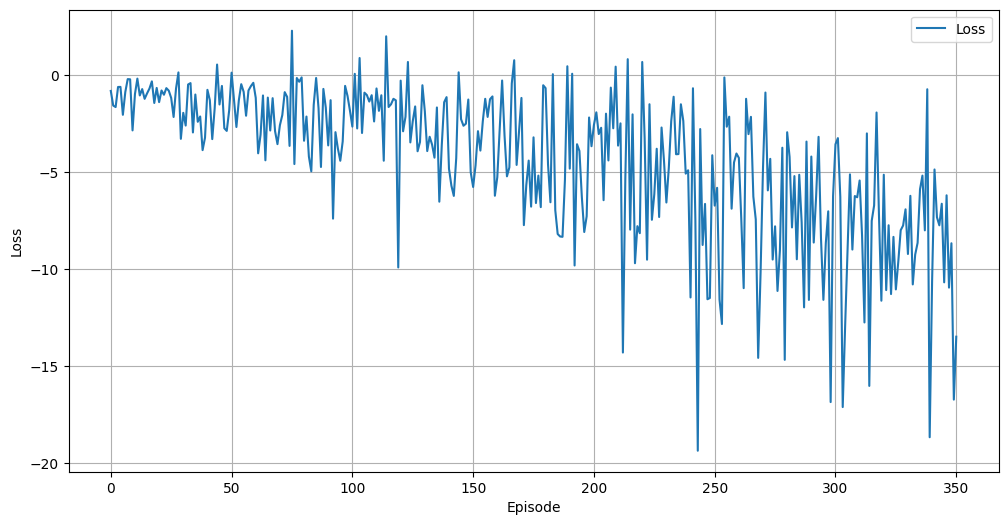

In [5]:
import matplotlib.pyplot as plt

# plot results
plt.figure(figsize=(12, 6))
plt.plot(history, label='Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()